# EMOTION RECOGNITION USING SPEECH SIGNAL

## Importing libraries

In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Image

%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import keras
from keras.layers import LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D #, AveragePooling1D
from keras.layers import Flatten, Dropout, Activation # Input, 
from keras.layers import Dense #, Embedding
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

import os
import sys
import csv
import librosa
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
np.random.seed(42)

Populating the interactive namespace from numpy and matplotlib


## Importing Datasets

In [2]:
!ls

Emotion_speech.ipynb
dataset_attr.csv
datasets


In [3]:
data, sampling_rate = librosa.load('datasets/anger/anger016.wav')
ipd.Audio('datasets/anger/anger016.wav')

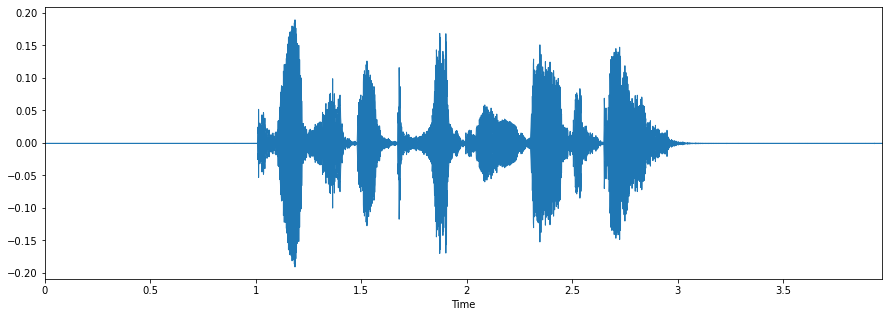

In [4]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

## SetUp

In [5]:
dataset_path = os.path.abspath('./datasets')
destination_path = os.path.abspath('./')

randomize = True

split = 0.8

sampling_rate = 20000 
emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]

## Converting the Dataset in CSV form for easy operation

In [6]:
def create_meta_csv(dataset_path, destination_path):
    DATASET_PATH = os.path.abspath(dataset_path)
    csv_path=os.path.join(destination_path, 'dataset_attr.csv')
    flist = []
    emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
    for root, dirs, files in os.walk(DATASET_PATH, topdown=False):
        for name in files:
            if (name.endswith('.wav')): 
                fullName = os.path.join(root, name)
                flist.append(fullName)

    split_format = str('/') if sys.platform=='linux' else str('\\')
    
    filenames=[]
    for idx,file in enumerate(flist):
        filenames.append(file.split(split_format)) 
    types=[]
    for idx,path in enumerate(filenames):
        types.append((flist[idx],emotions.index(path[-2]))) 

    with open(csv_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows([("path","label")])
        writer.writerows(types)
    f.close() 
    if destination_path == None:
        destination_path = DATASET_PATH
    return True

In [7]:
def train_test_split(dframe, split_ratio):
    train_data= dframe.iloc[:int((split_ratio) * len(dframe)), :]
    test_data= dframe.iloc[int((split_ratio) * len(dframe)):,:]
    test_data=test_data.reset_index(drop=True)
    return train_data, test_data

In [8]:
def create_and_load_meta_csv_df(dataset_path, destination_path, randomize=True, split=None):
    if create_meta_csv(dataset_path, destination_path=destination_path):
        dframe = pd.read_csv(os.path.join(destination_path, 'dataset_attr.csv'))
        
    if randomize == True or (split != None and randomize == None):
        dframe=dframe.sample(frac=1).reset_index(drop=True)
        pass

    if split != None:
        train_set, test_set = train_test_split(dframe, split)
        return dframe, train_set, test_set 
    
    return dframe

In [9]:
df, train_df, test_df = create_and_load_meta_csv_df(dataset_path, destination_path, randomize, split)

In [10]:
print('Dataset samples  : ', len(df),"\nTraining Samples : ", len(train_df),"\ntesting Samples  : ", len(test_df))

Dataset samples  :  2556 
Training Samples :  2044 
testing Samples  :  512


In [11]:
df.head()

,path,label
0,C:\Users\sagar\Desktop\summer_intern\datasets\...,3
1,C:\Users\sagar\Desktop\summer_intern\datasets\...,4
2,C:\Users\sagar\Desktop\summer_intern\datasets\...,5
3,C:\Users\sagar\Desktop\summer_intern\datasets\...,0
4,C:\Users\sagar\Desktop\summer_intern\datasets\...,3


In [12]:
print("Actual Audio : ", df['path'][0])
print("Labels       : ", df['label'][0])


Actual Audio :  C:\Users\sagar\Desktop\summer_intern\datasets\happy\happy143.wav
Labels       :  3



### Labels Assigned for emotions : 
- 0 : anger
- 1 : disgust
- 2 : fear
- 3 : happy
- 4 : neutral 
- 5 : sad
- 6 : surprise

In [13]:
unique_labels = train_df.label.unique()
unique_labels.sort()
print("unique labels in Emotion dataset : ")
print(*unique_labels, sep=', ')
unique_labels_counts = train_df.label.value_counts(sort=False)
print("\n\nCount of unique labels in Emotion dataset : ")
print(*unique_labels_counts,sep=', ')

unique labels in Emotion dataset : 
0, 1, 2, 3, 4, 5, 6


Count of unique labels in Emotion dataset : 
363, 201, 346, 346, 240, 353, 195


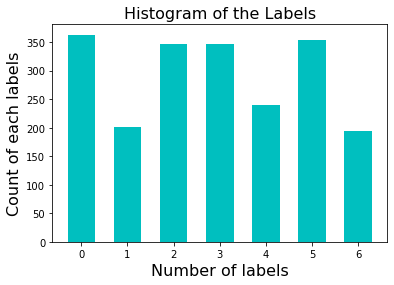

In [14]:
# Histogram of the classes
plt.bar(unique_labels, unique_labels_counts,align = 'center', width=0.6, color = 'c')
plt.xlabel('Number of labels', fontsize=16)
plt.xticks(unique_labels)
plt.ylabel('Count of each labels', fontsize=16)
plt.title('Histogram of the Labels', fontsize=16)
plt.show()

## Data Preprocessing

In [15]:
def get_audio_features(audio_path,sampling_rate):
    X, sample_rate = librosa.load(audio_path ,res_type='kaiser_fast',duration=2.5,sr=sampling_rate*2,offset=0.5)
    sample_rate = np.array(sample_rate)

    y_harmonic, y_percussive = librosa.effects.hpss(X)
    pitches, magnitudes = librosa.core.pitch.piptrack(y=X, sr=sample_rate)

    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),axis=1)

    pitches = np.trim_zeros(np.mean(pitches,axis=1))[:20]

    magnitudes = np.trim_zeros(np.mean(magnitudes,axis=1))[:20]

    C = np.mean(librosa.feature.chroma_cqt(y=y_harmonic, sr=sampling_rate),axis=1)
    
    return [mfccs, pitches, magnitudes, C]

In [16]:
def get_features_dataframe(dataframe, sampling_rate):
    labels = pd.DataFrame(dataframe['label'])
    
    features  = pd.DataFrame(columns=['mfcc','pitches','magnitudes','C'])
    for index, audio_path in enumerate(dataframe['path']):
        features.loc[index] = get_audio_features(audio_path, sampling_rate)
    
    mfcc = features.mfcc.apply(pd.Series)
    pit = features.pitches.apply(pd.Series)
    mag = features.magnitudes.apply(pd.Series)
    C = features.C.apply(pd.Series)
    
    combined_features = pd.concat([mfcc,pit,mag,C],axis=1,ignore_index=True)

    return combined_features, labels 

In [17]:
trainfeatures, trainlabel = get_features_dataframe(train_df, sampling_rate)
testfeatures, testlabel = get_features_dataframe(test_df, sampling_rate)

# it take too much time to generate features(around 30-40 minutes).

In [18]:
testfeatures.shape

(512, 65)

In [19]:
testfeatures

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-659.109863,107.033485,-6.693133,24.680651,12.433774,27.431477,-12.924296,-1.011764,-16.425858,0.839390,...,0.596354,0.546150,0.449644,0.476973,0.389553,0.454911,0.468581,0.501835,0.763113,0.445884
1,-359.337097,135.396057,29.976292,22.287416,33.277740,21.278490,-2.353922,-20.307564,-5.272031,5.622859,...,0.225397,0.204006,0.327707,0.547585,0.431166,0.350324,0.312365,0.274147,0.269731,0.369452
2,-424.558197,96.963341,-36.658127,12.789310,7.016811,10.546576,-44.985126,-4.165691,-10.516686,-6.899173,...,0.237681,0.328330,0.462783,0.521085,0.373701,0.436247,0.524780,0.440213,0.335033,0.239029
3,-684.459656,122.211617,13.808701,32.378250,7.091710,16.806190,2.673714,10.503845,-14.738984,-1.201517,...,0.198890,0.182925,0.146618,0.276222,0.561489,0.434911,0.303515,0.209726,0.307299,0.361811
4,-453.128754,63.102978,-31.018986,9.130228,-19.599939,-9.888313,-26.587467,-1.929676,-14.899186,-9.519525,...,0.201760,0.249076,0.467310,0.651789,0.393104,0.247398,0.210489,0.281166,0.140211,0.171004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,-603.679260,108.326454,12.858300,21.468386,6.208854,16.775209,-15.499043,1.711327,-17.639275,9.085896,...,0.235327,0.250801,0.417099,0.362768,0.265614,0.260186,0.420013,0.367182,0.310030,0.312512
508,-230.178207,152.417343,-11.136343,13.419801,12.563170,-18.277920,-10.958452,-6.391010,-10.596009,-14.867143,...,0.336724,0.262129,0.212499,0.316623,0.318286,0.409770,0.380309,0.219621,0.176076,0.182232
509,-629.786804,112.197823,-7.868087,18.193459,12.262894,17.530594,-11.820210,5.692108,-14.382519,2.810680,...,0.235479,0.301906,0.371371,0.418674,0.451351,0.362528,0.463247,0.418647,0.521734,0.411884
510,-373.518585,73.414040,-13.940181,12.762763,-16.306402,8.247673,-11.527452,-10.387094,-19.614153,-0.372376,...,0.360621,0.346361,0.364660,0.330097,0.311535,0.382393,0.392058,0.404278,0.551856,0.403519


In [20]:
trainfeatures.shape

(2044, 65)

In [21]:
trainfeatures = trainfeatures.fillna(0)
testfeatures = testfeatures.fillna(0)

In [22]:
# By using .ravel() : Converting 2D to 1D e.g. (512,1) -> (512,). To prevent DataConversionWarning

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel).ravel()
X_test = np.array(testfeatures)
y_test = np.array(testlabel).ravel()


In [23]:
y_train[:5]

array([3, 4, 5, 0, 3], dtype=int64)

In [24]:
# One-Hot Encoding
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [25]:
y_train[:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [26]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [27]:
x_traincnn.shape

(2044, 65, 1)

In [28]:
x_traincnn

array([[[-4.9484503e+02],
        [ 5.9179066e+01],
        [-1.9713564e+01],
        ...,
        [ 4.6515578e-01],
        [ 4.1139019e-01],
        [ 3.8325244e-01]],

       [[-4.4133920e+02],
        [ 1.8174518e+02],
        [ 3.4695473e+01],
        ...,
        [ 5.0352931e-01],
        [ 6.6676784e-01],
        [ 4.3854597e-01]],

       [[-5.7308710e+02],
        [ 1.0131611e+02],
        [-3.3149695e+00],
        ...,
        [ 2.8663105e-01],
        [ 3.7585950e-01],
        [ 4.3715364e-01]],

       ...,

       [[-4.9662503e+02],
        [ 1.0270155e+02],
        [-7.5837727e+00],
        ...,
        [ 5.1182556e-01],
        [ 5.7763743e-01],
        [ 3.7260032e-01]],

       [[-3.1836768e+02],
        [ 1.0411601e+02],
        [ 7.9768233e+00],
        ...,
        [ 4.9700156e-01],
        [ 4.0075794e-01],
        [ 4.6224463e-01]],

       [[-3.8124066e+02],
        [ 8.8543526e+01],
        [-4.6633209e+01],
        ...,
        [ 4.7516558e-01],
        [ 3.551

# Building Model

In [29]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 65, 256)           1536      
_________________________________________________________________
activation (Activation)      (None, 65, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 65, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 65, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 65, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            8

In [31]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [32]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=380, validation_data=(x_testcnn, y_test))

Epoch 1/380
128/128 [==============================] - 2s 14ms/step - loss: 2.1742 - accuracy: 0.1908 - val_loss: 1.9038 - val_accuracy: 0.2090
Epoch 2/380
128/128 [==============================] - 2s 13ms/step - loss: 1.8389 - accuracy: 0.2750 - val_loss: 1.7906 - val_accuracy: 0.2598
Epoch 3/380
128/128 [==============================] - 2s 14ms/step - loss: 1.7698 - accuracy: 0.2965 - val_loss: 1.7353 - val_accuracy: 0.3203
Epoch 4/380
128/128 [==============================] - 2s 13ms/step - loss: 1.7028 - accuracy: 0.3400 - val_loss: 1.7086 - val_accuracy: 0.2988
Epoch 5/380
128/128 [==============================] - 2s 13ms/step - loss: 1.6887 - accuracy: 0.3327 - val_loss: 1.6499 - val_accuracy: 0.3633
Epoch 6/380
128/128 [==============================] - 2s 13ms/step - loss: 1.6372 - accuracy: 0.3518 - val_loss: 1.6528 - val_accuracy: 0.3574
Epoch 7/380
128/128 [==============================] - 2s 13ms/step - loss: 1.6173 - accuracy: 0.3772 - val_loss: 1.6203 - val_accuracy:

Epoch 57/380
128/128 [==============================] - 2s 13ms/step - loss: 1.1756 - accuracy: 0.5641 - val_loss: 1.3392 - val_accuracy: 0.4844
Epoch 58/380
128/128 [==============================] - 2s 13ms/step - loss: 1.1693 - accuracy: 0.5577 - val_loss: 1.3083 - val_accuracy: 0.5020
Epoch 59/380
128/128 [==============================] - 2s 12ms/step - loss: 1.1713 - accuracy: 0.5626 - val_loss: 1.3046 - val_accuracy: 0.5078
Epoch 60/380
128/128 [==============================] - 2s 13ms/step - loss: 1.1619 - accuracy: 0.5587 - val_loss: 1.2988 - val_accuracy: 0.4961
Epoch 61/380
128/128 [==============================] - 2s 12ms/step - loss: 1.1627 - accuracy: 0.5744 - val_loss: 1.3117 - val_accuracy: 0.5020
Epoch 62/380
128/128 [==============================] - 2s 13ms/step - loss: 1.1468 - accuracy: 0.5846 - val_loss: 1.2972 - val_accuracy: 0.4922
Epoch 63/380
128/128 [==============================] - 2s 13ms/step - loss: 1.1510 - accuracy: 0.5695 - val_loss: 1.3152 - val_ac

128/128 [==============================] - 2s 13ms/step - loss: 0.9539 - accuracy: 0.6673 - val_loss: 1.2225 - val_accuracy: 0.5332
Epoch 114/380
128/128 [==============================] - 2s 13ms/step - loss: 0.9662 - accuracy: 0.6502 - val_loss: 1.2213 - val_accuracy: 0.5371
Epoch 115/380
128/128 [==============================] - 2s 13ms/step - loss: 0.9667 - accuracy: 0.6517 - val_loss: 1.2120 - val_accuracy: 0.5352
Epoch 116/380
128/128 [==============================] - 2s 13ms/step - loss: 0.9602 - accuracy: 0.6463 - val_loss: 1.2137 - val_accuracy: 0.5215
Epoch 117/380
128/128 [==============================] - 2s 13ms/step - loss: 0.9590 - accuracy: 0.6433 - val_loss: 1.2308 - val_accuracy: 0.5254
Epoch 118/380
128/128 [==============================] - 2s 13ms/step - loss: 0.9707 - accuracy: 0.6463 - val_loss: 1.2225 - val_accuracy: 0.5312
Epoch 119/380
128/128 [==============================] - 2s 13ms/step - loss: 0.9591 - accuracy: 0.6570 - val_loss: 1.2124 - val_accuracy:

128/128 [==============================] - 2s 15ms/step - loss: 0.8191 - accuracy: 0.7182 - val_loss: 1.1642 - val_accuracy: 0.5742
Epoch 170/380
128/128 [==============================] - 2s 14ms/step - loss: 0.8220 - accuracy: 0.7162 - val_loss: 1.1778 - val_accuracy: 0.5586
Epoch 171/380
128/128 [==============================] - ETA: 0s - loss: 0.8017 - accuracy: 0.7334 ETA - 2s 13ms/step - loss: 0.8017 - accuracy: 0.7334 - val_loss: 1.1660 - val_accuracy: 0.5547
Epoch 172/380
128/128 [==============================] - 2s 13ms/step - loss: 0.8169 - accuracy: 0.7216 - val_loss: 1.1665 - val_accuracy: 0.5566
Epoch 173/380
128/128 [==============================] - 2s 13ms/step - loss: 0.8185 - accuracy: 0.7030 - val_loss: 1.1713 - val_accuracy: 0.5684
Epoch 174/380
128/128 [==============================] - 2s 13ms/step - loss: 0.8082 - accuracy: 0.7182 - val_loss: 1.1502 - val_accuracy: 0.5723
Epoch 175/380
128/128 [==============================] - 2s 13ms/step - loss: 0.8091 - acc

Epoch 225/380
128/128 [==============================] - 2s 13ms/step - loss: 0.6973 - accuracy: 0.7632 - val_loss: 1.1329 - val_accuracy: 0.5703
Epoch 226/380
128/128 [==============================] - 2s 13ms/step - loss: 0.7207 - accuracy: 0.7466 - val_loss: 1.1507 - val_accuracy: 0.5859
Epoch 227/380
128/128 [==============================] - 2s 13ms/step - loss: 0.7115 - accuracy: 0.7520 - val_loss: 1.1228 - val_accuracy: 0.5723
Epoch 228/380
128/128 [==============================] - 2s 13ms/step - loss: 0.7181 - accuracy: 0.7402 - val_loss: 1.1382 - val_accuracy: 0.5684
Epoch 229/380
128/128 [==============================] - 2s 13ms/step - loss: 0.7106 - accuracy: 0.7534 - val_loss: 1.1871 - val_accuracy: 0.5762
Epoch 230/380
128/128 [==============================] - 2s 13ms/step - loss: 0.6974 - accuracy: 0.7686 - val_loss: 1.1417 - val_accuracy: 0.5820 0s - los
Epoch 231/380
128/128 [==============================] - 2s 13ms/step - loss: 0.7036 - accuracy: 0.7578 - val_loss:

128/128 [==============================] - 2s 13ms/step - loss: 0.6250 - accuracy: 0.7852 - val_loss: 1.1625 - val_accuracy: 0.5898
Epoch 282/380
128/128 [==============================] - 2s 13ms/step - loss: 0.6111 - accuracy: 0.7872 - val_loss: 1.1283 - val_accuracy: 0.5898
Epoch 283/380
128/128 [==============================] - 2s 13ms/step - loss: 0.6165 - accuracy: 0.7970 - val_loss: 1.1493 - val_accuracy: 0.5723
Epoch 284/380
128/128 [==============================] - 2s 13ms/step - loss: 0.6151 - accuracy: 0.7886 - val_loss: 1.1406 - val_accuracy: 0.5898
Epoch 285/380
128/128 [==============================] - 2s 13ms/step - loss: 0.6001 - accuracy: 0.7999 - val_loss: 1.1134 - val_accuracy: 0.5801
Epoch 286/380
128/128 [==============================] - 2s 13ms/step - loss: 0.6183 - accuracy: 0.7935 - val_loss: 1.1251 - val_accuracy: 0.5742
Epoch 287/380
128/128 [==============================] - 2s 13ms/step - loss: 0.6177 - accuracy: 0.7838 - val_loss: 1.1916 - val_accuracy:

128/128 [==============================] - 2s 13ms/step - loss: 0.5466 - accuracy: 0.8151 - val_loss: 1.1184 - val_accuracy: 0.5879
Epoch 338/380
128/128 [==============================] - 2s 13ms/step - loss: 0.5330 - accuracy: 0.8165 - val_loss: 1.1501 - val_accuracy: 0.5664
Epoch 339/380
128/128 [==============================] - 2s 13ms/step - loss: 0.5319 - accuracy: 0.8234 - val_loss: 1.1699 - val_accuracy: 0.5879
Epoch 340/380
128/128 [==============================] - 2s 13ms/step - loss: 0.5346 - accuracy: 0.8185 - val_loss: 1.1569 - val_accuracy: 0.5742
Epoch 341/380
128/128 [==============================] - 2s 13ms/step - loss: 0.5392 - accuracy: 0.8195 - val_loss: 1.1445 - val_accuracy: 0.5879 0s - l
Epoch 342/380
128/128 [==============================] - 2s 13ms/step - loss: 0.5467 - accuracy: 0.8170 - val_loss: 1.1271 - val_accuracy: 0.5898
Epoch 343/380
128/128 [==============================] - 2s 13ms/step - loss: 0.5278 - accuracy: 0.8229 - val_loss: 1.1212 - val_ac

In [74]:
def plot_learningCurve(history):
    epoch_range = range(1, 381)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()

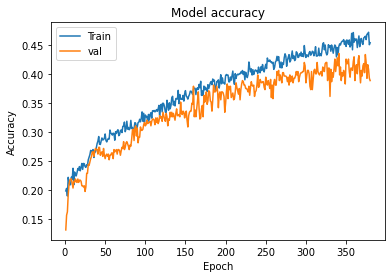

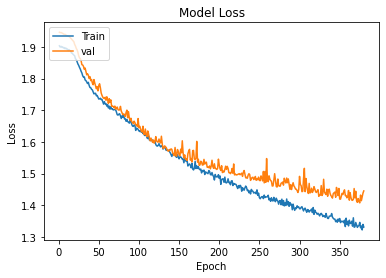

In [76]:
plot_learningCurve(cnnhistory)